In [370]:
import os
import re
import io
import ast
import sys
import json
import boto3 
import pymongo 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from urllib import request

sys.path.append("../")
import cabutils

## Downloading data from ec2 server 

In `settings.conf` change the `MONGODB_PORT` to 8000, and the `MONGODB_HOST` to `localhost`. Then run the ssh port into the ec2 server: 

```
ssh -i path/to/ec2-server.pem -NL 8000:localhost:27017 ubuntu@ec2-34-228-26-201.compute-1.amazonaws.com
```

Change the path to the pem key, but otherwise this should all stay the same.

In [377]:
projName = "mlve"
S3_BUCKET_NAME = "mlve-v1"
                  
download_results = { # experimentName: iterNames}
    "gestalt_video-object-loc": ["72222_gestalt_superquadric"],
    "gestalt_shapegen_video-object-loc": ["72222_gestalt_shapegen_video-object-loc"],
    "gestalt_object-loc": ["72122_gestalt_superquadric"],
    "gestalt_shapegen_object-loc": ["72122_gestalt_shapegen"]
}
             

In [378]:
def results_to_df():
    conn = cabutils.get_db_connection()
    all_dfs = []
    for experimentName, iterNames in download_results.items():
        print(f"Downloading results for experiment: {experimentName}")
        db = conn[projName + "_outputs"]
        col = db[experimentName]
        
        results = []
        cursor = col.find({})
        for document in cursor:
            results.append(document)

        df = pd.DataFrame(results)
        all_dfs.append(df)
        
    super_df = pd.concat(all_dfs)
    return super_df

df = results_to_df()
df.head(10)

Checking database connection...
Connection established!


,_id,image_url,video_url,probe_touching,probe_location,gt_bounding_box,mask_idx,mask_val,meta,is_duplicate,...,time_elapsed,internal_node_id,gameid,iterationName,inputid,projName,expName,sessionID,studyID,userID
0,62db1f14b2d53803fc35a835,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[84, 212]","[[7, 135], [289, 377]]",0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,...,414402,0.0-21.0,7542-f3578d2f-cf4d-4d6b-b23c-e469793cc70a,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1d69a3cbbbcf9337ff2a,62db1b97111431d2a61f9bc1,61424b1673fc4394db65bc53
1,62db1f29b2d53803fc35a879,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[425, 99]","[[197, 0], [511, 207]]",0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,...,436195,0.0-24.0,7542-f3578d2f-cf4d-4d6b-b23c-e469793cc70a,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1d69a3cbbbcf9337ff2a,62db1b97111431d2a61f9bc1,61424b1673fc4394db65bc53
2,62db1f35b2d53803fc35a89a,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[188, 248]",[],0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,...,447518,0.0-27.0,7542-f3578d2f-cf4d-4d6b-b23c-e469793cc70a,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1d69a3cbbbcf9337ff2a,62db1b97111431d2a61f9bc1,61424b1673fc4394db65bc53
3,62db1f40b2d53803fc35a8bf,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[67, 327]",[],0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,...,458898,0.0-30.0,7542-f3578d2f-cf4d-4d6b-b23c-e469793cc70a,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1d69a3cbbbcf9337ff2a,62db1b97111431d2a61f9bc1,61424b1673fc4394db65bc53
4,62db1f4cb2d53803fc35a8e7,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[194, 398]",[],0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,...,470532,0.0-33.0,7542-f3578d2f-cf4d-4d6b-b23c-e469793cc70a,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1d69a3cbbbcf9337ff2a,62db1b97111431d2a61f9bc1,61424b1673fc4394db65bc53
5,62db1f60b2d53803fc35a917,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[355, 266]","[[259, 210], [511, 430]]",0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,...,490588,0.0-36.0,7542-f3578d2f-cf4d-4d6b-b23c-e469793cc70a,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1d69a3cbbbcf9337ff2a,62db1b97111431d2a61f9bc1,61424b1673fc4394db65bc53
6,62db1f74b2d53803fc35a94e,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[208, 299]","[[134, 274], [320, 347]]",0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,...,510824,0.0-39.0,7542-f3578d2f-cf4d-4d6b-b23c-e469793cc70a,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1d69a3cbbbcf9337ff2a,62db1b97111431d2a61f9bc1,61424b1673fc4394db65bc53
7,62db1f7fb2d53803fc35a970,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[151, 240]",[],0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,...,522202,0.0-42.0,7542-f3578d2f-cf4d-4d6b-b23c-e469793cc70a,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1d69a3cbbbcf9337ff2a,62db1b97111431d2a61f9bc1,61424b1673fc4394db65bc53
8,62db1f87b2d53803fc35a989,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[303, 92]","[[36, 0], [468, 370]]",1.0,60.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,...,408215,0.0-21.0,7714-dfb7ac3a-542e-4475-adab-9a9430cdf929,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1dccbdc802f275584463,62db1b97111431d2a61f9bc1,

In [379]:
def download_from_s3(url, resource_type="image"):
    s3 = boto3.resource('s3', region_name="us-east-2")
    bucket = s3.Bucket(S3_BUCKET_NAME)
    item = bucket.Object(url)
    if resource_type == "image":
        file_stream = io.BytesIO()
        item.download_fileobj(file_stream)
        img = Image.open(file_stream)
        return img
    
    else:
        return item

In [380]:
def download_from_url(url):
    obj = request.urlretrieve(url)
    image = Image.open(obj[0])
    return image

In [381]:
def process_box(box):
    """
    Expects box as a tuple, of start stop points. Returns it as: [minX, minY, maxX, maxY]
    """
    minX = min(box[0][0], box[1][0])
    maxX = max(box[0][0], box[1][0])
    
    minY = min(box[0][1], box[1][1])
    maxY = max(box[0][1], box[1][1])
    
    return [int(minX), int(minY), int(maxX), int(maxY)]

def calc_mIOU(box_a, box_b, epsilon=1e-8):
    if not box_a and not box_b:
        return float("nan")
    if not box_a or not box_a:
        return 0
    
    if len(box_a) < 4:
        a = process_box(box_a)
    else:
        a = box_a
    
    if len(box_b) < 4:
        b = process_box(box_b)
    else:
        b = box_b
        
    # return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

    # COORDINATES OF THE INTERSECTION BOX
    
    xA = max(a[0], b[0])
    yA = max(a[1], b[1])
    xB = min(a[2], b[2])
    yB = min(a[3], b[3])
    
    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both AABBs
    bb1_area = (a[2] - a[0] + 1) * (a[3] - a[1] + 1)
    bb2_area = (b[2] - b[0] + 1) * (b[3] - b[1] + 1)
    if intersection_area == (bb1_area + bb2_area):
        return float('nan')
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou


In [382]:
# df.to_csv(EXPERIMENT_NAME + "-results.csv")

In [383]:
df["correct"].mean()

0.9185126007698453

In [384]:
df[df["expName"] == "gestalt_shapegen_object-loc"]["correct"].mean()

0.8917972911276822

In [385]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27856 entries, 0 to 6651
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _id                   27856 non-null  object 
 1   image_url             27538 non-null  object 
 2   video_url             13014 non-null  object 
 3   probe_touching        27538 non-null  object 
 4   probe_location        27538 non-null  object 
 5   gt_bounding_box       27538 non-null  object 
 6   mask_idx              27538 non-null  float64
 7   mask_val              27538 non-null  float64
 8   meta                  27538 non-null  object 
 9   is_duplicate          27538 non-null  object 
 10  attention_check       27538 non-null  object 
 11  batch_num             27538 non-null  float64
 12  rt                    27856 non-null  int64  
 13  stimulus              27538 non-null  object 
 14  response              27856 non-null  object 
 15  correct             

In [386]:
sns.set_context("poster")

In [387]:
df["Trial Type"] = df["expName"].apply(lambda x: "Static" if "video" not in x else "Dynamic")

In [388]:
def trial_description(x):
    if x == "gestalt_object-loc":
        return "Static Simple Shapes"
    elif x == "gestalt_video-object-loc":
        return "Dynamic Simple Shapes"
    elif x == "gestalt_shapegen_video-object-loc":
        return "Dynamic Complex Shapes"
    else:
        return "Static Complex Shapes"
    
df["Trial Description"] = df["expName"].apply(lambda x: trial_description(x))

In [389]:
fig = plt.figure(figsize=(12, 8))
sns.displot(x="miou", hue="Trial Description", data=df[df["miou"] != 0].reset_index(), kind="kde", 
            multiple="stack", height=8.27, aspect=11.7/8.27)

plt.xlabel("Participant Bounding Box IOUs")
plt.show()

KeyError: 'miou'

<Figure size 864x576 with 0 Axes>

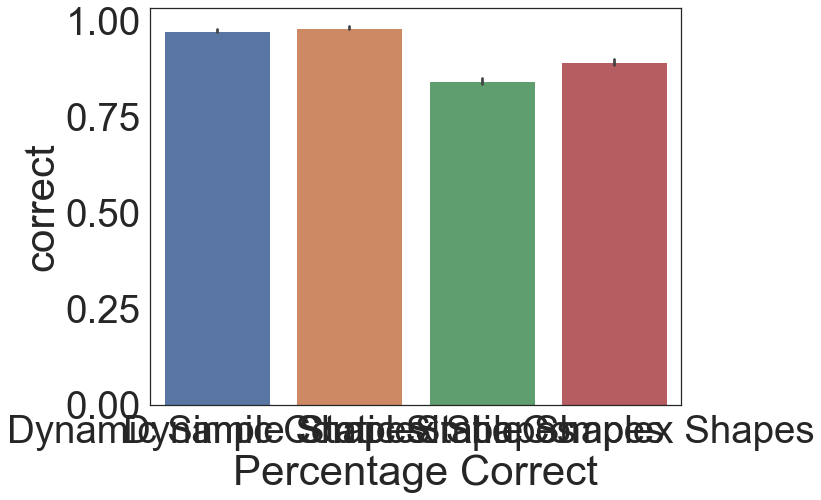

In [457]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()
g = sns.barplot(x="Trial Description", y="correct", data=df, order=["Dynamic Shapes", 
                                                           
                                                           "Static Shapes",
                                                           ], ax=ax)
plt.xlabel("Percentage Correct")
plt.savefig(f"figures/cogsci2022_overall-accuracy_bbox_gestalt.eps", format="eps")
plt.tight_layout()
plt.show()

# Generate cleaned version

In [390]:
df.head()

,_id,image_url,video_url,probe_touching,probe_location,gt_bounding_box,mask_idx,mask_val,meta,is_duplicate,...,gameid,iterationName,inputid,projName,expName,sessionID,studyID,userID,Trial Type,Trial Description
0,62db1f14b2d53803fc35a835,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[84, 212]","[[7, 135], [289, 377]]",0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,...,7542-f3578d2f-cf4d-4d6b-b23c-e469793cc70a,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1d69a3cbbbcf9337ff2a,62db1b97111431d2a61f9bc1,61424b1673fc4394db65bc53,Dynamic,Dynamic Simple Shapes
1,62db1f29b2d53803fc35a879,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[425, 99]","[[197, 0], [511, 207]]",0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,...,7542-f3578d2f-cf4d-4d6b-b23c-e469793cc70a,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1d69a3cbbbcf9337ff2a,62db1b97111431d2a61f9bc1,61424b1673fc4394db65bc53,Dynamic,Dynamic Simple Shapes
2,62db1f35b2d53803fc35a89a,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[188, 248]",[],0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,...,7542-f3578d2f-cf4d-4d6b-b23c-e469793cc70a,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1d69a3cbbbcf9337ff2a,62db1b97111431d2a61f9bc1,61424b1673fc4394db65bc53,Dynamic,Dynamic Simple Shapes
3,62db1f40b2d53803fc35a8bf,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[67, 327]",[],0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,...,7542-f3578d2f-cf4d-4d6b-b23c-e469793cc70a,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1d69a3cbbbcf9337ff2a,62db1b97111431d2a61f9bc1,61424b1673fc4394db65bc53,Dynamic,Dynamic Simple Shapes
4,62db1f4cb2d53803fc35a8e7,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[194, 398]",[],0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,...,7542-f3578d2f-cf4d-4d6b-b23c-e469793cc70a,72222_gestalt_superquadric,None,mlve,gestalt_video-object-loc,62db1d69a3cbbbcf9337ff2a,62db1b97111431d2a61f9bc1,61424b1673fc4394db65bc53,Dynamic,Dynamic Simple Shapes


In [391]:
df[df["userID"] == "5c8d5260f756d400166838d9"]

,_id,image_url,video_url,probe_touching,probe_location,gt_bounding_box,mask_idx,mask_val,meta,is_duplicate,...,gameid,iterationName,inputid,projName,expName,sessionID,studyID,userID,Trial Type,Trial Description


## Let's quickly look at the comments

In [392]:
all_comments = df[df["trial_type"] == "survey-text"]["response"]
comments = []
for response in all_comments:
    comm = response["Q0"]
    if len(comm) > 0:
        print(comm)
        comments.append(comm)
# print(comments)

Finish
Very interesting, is it something to do with camouflaging new vehicles?
i wish the red box was able to be moved to fix the sides of the object better
Its quite interesting
Shapes that go off the edge of the screen are difficult to put the square around
No thank you. I think it was easier than I initially imagined
Drawing the marquee was sometimes so infuriating I had to give up and just accept "close-enough", especially near the edges. This made me lose focus and I welcomed the "no" frames to attempt to get centred again. 
I liked the monkey pic
I really enjoyed the picture. Also please send me more studies.
The hardest part for me was getting the box to draw where I wanted it to  lol.  Great study, it was like a game.  Thanks
No. The study is interesting.
I found the study fun as it engaged me.
No
Thanks for the nice picture in the middle of experiment :)
I enjoyed this study. I could do this all day.
none
No
Don't know if this was deliberate, but having to look away from the i

In [393]:
df.drop(df[df["trial_type"] != "object-localization-task"].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26717 entries, 0 to 6650
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _id                   26717 non-null  object 
 1   image_url             26717 non-null  object 
 2   video_url             12621 non-null  object 
 3   probe_touching        26717 non-null  object 
 4   probe_location        26717 non-null  object 
 5   gt_bounding_box       26717 non-null  object 
 6   mask_idx              26717 non-null  float64
 7   mask_val              26717 non-null  float64
 8   meta                  26717 non-null  object 
 9   is_duplicate          26717 non-null  object 
 10  attention_check       26717 non-null  object 
 11  batch_num             26717 non-null  float64
 12  rt                    26717 non-null  int64  
 13  stimulus              26717 non-null  object 
 14  response              26717 non-null  object 
 15  correct             

In [395]:
participants = df.groupby("userID")
participants_failed = []j
i = 0 
n_trials = 81j
score_threshold = 0.5


for index, user_results in participants:
    i += 1
    trials_finished = len(user_results)
    if trials_finished < n_trials - 10:
        print("USER ID: " + user_results["userID"].iloc[0] + " only completed: " + str(trials_finished) + " trials")
        participants_failed.append(user_results["userID"].iloc[0])
        continue
    
    correct_score = user_results["correct"].mean()
    if correct_score < score_threshold:
        print("USER ID: " + user_results["userID"].iloc[0] + " scored " + str(correct_score))
        participants_failed.append(user_results["userID"].iloc[0])
        continue
        
#     attention_checks = user_results[user_results["stimulus"].str.contains("ground_truth")]
#     if attention_checks["correct"].sum() < 2:
#         print("USER ID: " + user_results["userID"].iloc[0] + " faled too many attention checks")
#         participants_failed.append(user_results["userID"].iloc[0])

# participants_failed.append("60cb62a4e099dcbffe591021")
# participants_failed.append("5ec3d06016290204b072564d")
print(participants_failed)

SyntaxError: invalid syntax (263443531.py, line 2)

In [396]:
remove_failure_cases = True

In [397]:
if remove_failure_cases:
    failed_participants = df["userID"].apply(lambda x: x in participants_failed)
    df = df[~failed_participants]
    attention_checks = df["stimulus"].apply(lambda x: "ground_truth" in x)
    df = df[~attention_checks]

# Create directory for figures

In [398]:
if not os.path.exists(f"figures/{experimentName}"):
    os.makedirs(f"figures/{experimentName}")

## Create texture_name column

In [399]:
ious = []
for index, row in df.iterrows():
    gtbb = row["gt_bounding_box"]
    if type(gtbb) == str:
        gtbb = str_to_list(gtbb)
    ubb = row["subject_bounding_box"]
    if type(ubb) == str:
        ubb = str_to_list(ubb)

    if (not ubb and not gtbb) or (ubb and not gtbb):
        ious.append(float("nan"))
        continue 

    elif (not ubb and gtbb):
        ious.append(0)
        continue

    else:
        iou = calc_mIOU(gtbb, ubb)
        ious.append(iou)

df["miou"] = ious

In [400]:
user_means = df.groupby("userID")["miou"].mean()
low_miou = user_means[user_means < 0.2]
low_miou_user_ids = [x for x in low_miou.keys()]
all_participants_failed = low_miou_user_ids

In [159]:
participants_failed

[]

In [435]:
sns.set_context("poster")
sns.set(font_scale=3.5)
sns.set_style("white")

<Figure size 864x576 with 0 Axes>

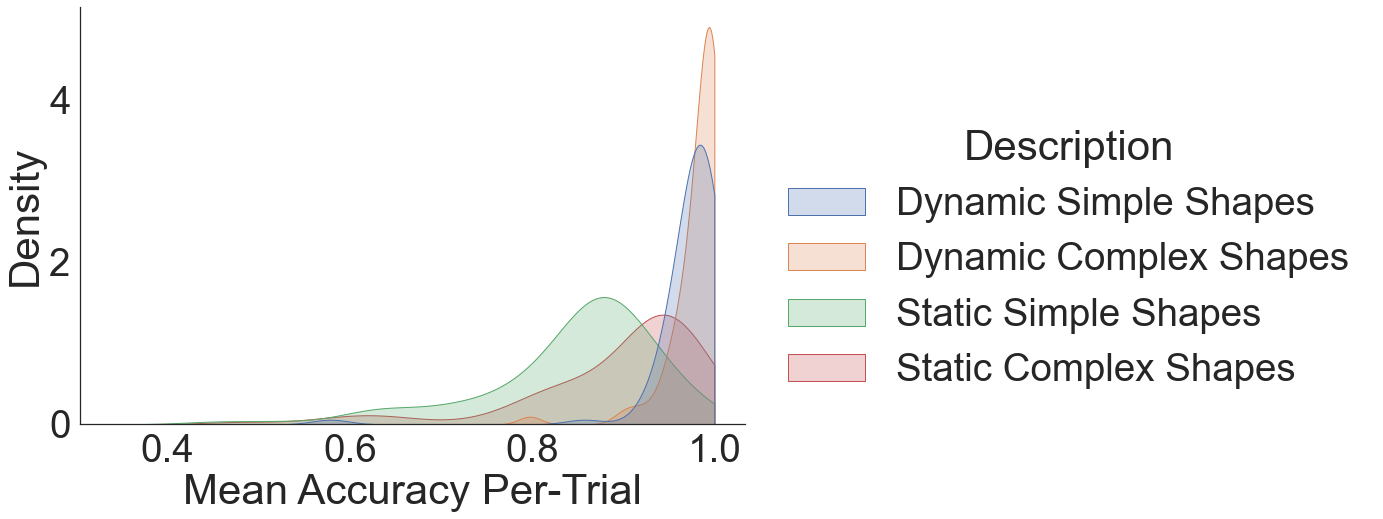

In [436]:
accuracies = []
textures = []
targets = ["stimulus", "Trial Description"]
challenging_stimuli = []
for (userID, description), trials in df.groupby(targets): 
    accuracy = trials["correct"].mean()
    accuracies.append({"Accuracy": accuracy, "Description": description})
#     accuracies.append(accuracy)
    

accuracy_df = pd.DataFrame(accuracies)            
figure = plt.figure(figsize=(12,8))
sns.displot(x="Accuracy", hue="Description", data=accuracy_df, kind="kde", 
           height=8.27, aspect=11.7/8.27, fill=True, clip=[0, 1], hue_order=["Dynamic Simple Shapes", 
                                                           "Dynamic Complex Shapes",
                                                           "Static Simple Shapes",
                                                           "Static Complex Shapes"])

plt.xlabel("Mean Accuracy Per-Trial")
plt.savefig(f"figures/cogsci2022_trial-accuracy_bbox_gestalt.svg", format="svg")
plt.show()


<Figure size 864x576 with 0 Axes>

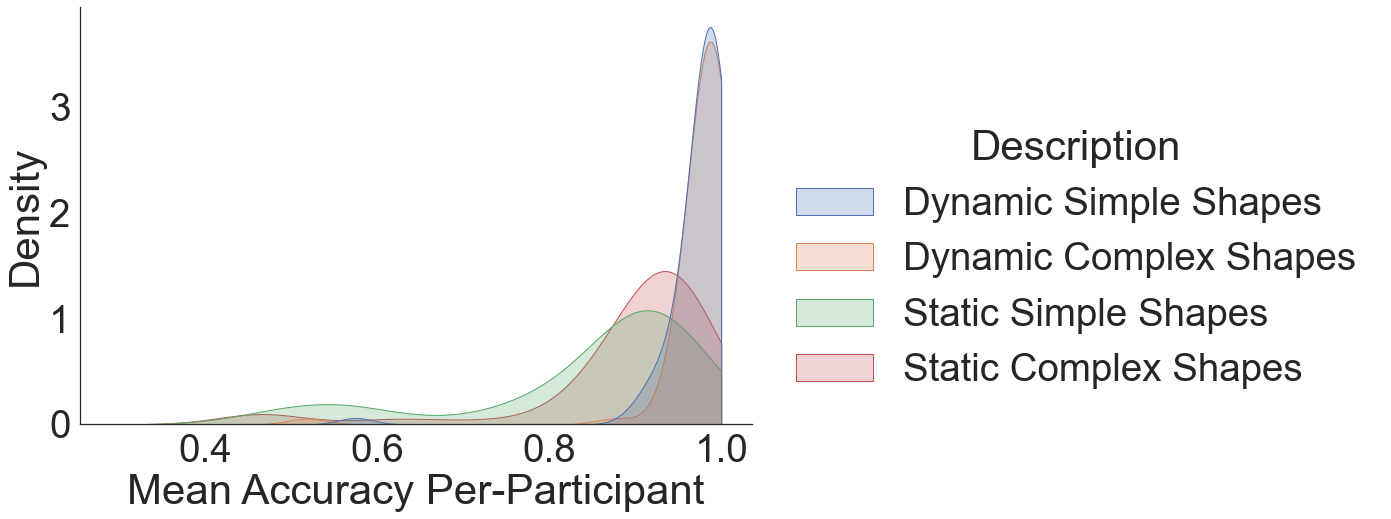

In [437]:
accuracies = []
textures = []
targets = ["userID", "Trial Description"]
challenging_stimuli = []
for (userID, description), trials in df.groupby(targets): 
    accuracy = trials["correct"].mean()
    accuracies.append({"Accuracy": accuracy, "Description": description})
#     accuracies.append(accuracy)
    

accuracy_df = pd.DataFrame(accuracies)            
figure = plt.figure(figsize=(12,8))
sns.displot(x="Accuracy", hue="Description", data=accuracy_df, kind="kde", 
           height=8.27, aspect=11.7/8.2, clip=[0, 1], fill=True, hue_order=["Dynamic Simple Shapes", 
                                                           "Dynamic Complex Shapes",
                                                           "Static Simple Shapes",
                                                           "Static Complex Shapes"])

plt.xlabel("Mean Accuracy Per-Participant")
plt.savefig(f"figures/cogsci2022_participant-accuracy_bbox_gestalt.svg", format="svg")

plt.show()
# plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")

<Figure size 864x576 with 0 Axes>

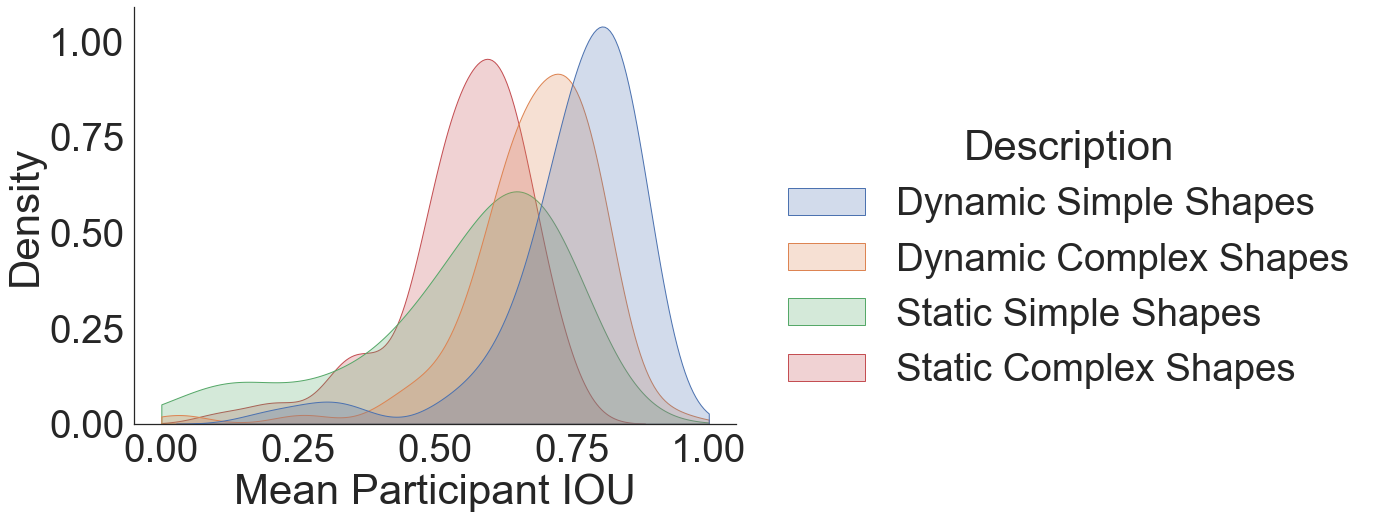

In [438]:
accuracies = []
textures = []
targets = ["userID", "Trial Description"]
challenging_stimuli = []
for (userID, description), trials in df.groupby(targets): 
    accuracy = trials["miou"].mean()
    accuracies.append({"IOU": accuracy, "Description": description})
#     accuracies.append(accuracy)
    

iou_df = pd.DataFrame(accuracies)            
figure = plt.figure(figsize=(12,8))
sns.displot(x="IOU", hue="Description", data=iou_df, kind="kde", fill=True,
           height=8.27, aspect=11.7/8.27, clip=[0, 1], hue_order=["Dynamic Simple Shapes", 
                                                           "Dynamic Complex Shapes",
                                                           "Static Simple Shapes",
                                                           "Static Complex Shapes"])

plt.xlabel("Mean Participant IOU")
plt.savefig(f"figures/cogsci2022_participant-iou_bbox_gestalt.svg", format="svg")

# plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")

<Figure size 864x576 with 0 Axes>

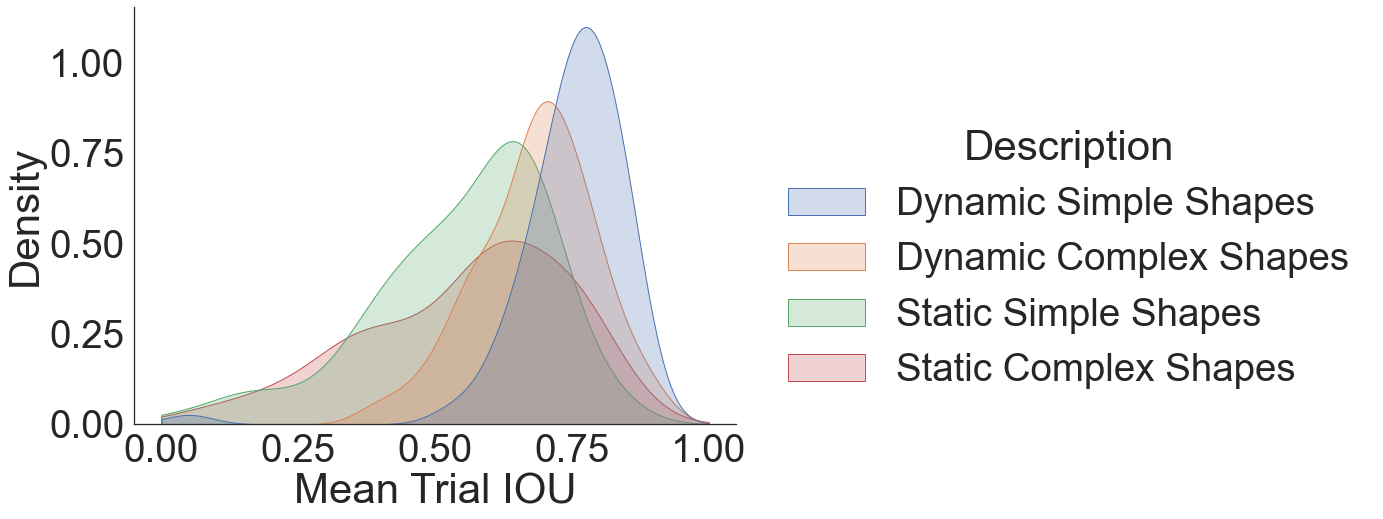

In [439]:
accuracies = []
textures = []
targets = ["stimulus", "Trial Description"]
challenging_stimuli = []
for (userID, description), trials in df.groupby(targets): 
    accuracy = trials["miou"].mean()
    accuracies.append({"IOU": accuracy, "Description": description})
#     accuracies.append(accuracy)
    

iou_df = pd.DataFrame(accuracies)            
figure = plt.figure(figsize=(12,8))
sns.displot(x="IOU", hue="Description", data=iou_df, kind="kde", fill=True,
           height=8.27, aspect=11.7/8.27, clip=[0, 1], hue_order=["Dynamic Simple Shapes", 
                                                           "Dynamic Complex Shapes",
                                                           "Static Simple Shapes",
                                                           "Static Complex Shapes"])

plt.xlabel("Mean Trial IOU")
plt.savefig(f"figures/cogsci2022_trial-iou_bbox_gestalt.svg", format="svg")

# plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")

Text(0.5, 1.0, 'Trial level accuracy')

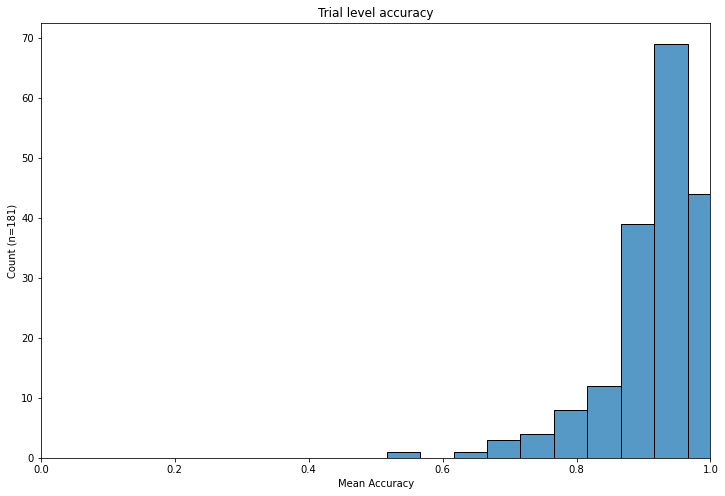

In [165]:
accuracies = []
textures = []
target = "stimulus"
challenging_stimuli = []
for index, trials in df.groupby(target): 
    accuracy = trials["correct"].mean()
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("Mean Accuracy")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"Trial level accuracy")
# plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")

#  mIOU


Text(0.5, 1.0, 'mIOU per-participant')

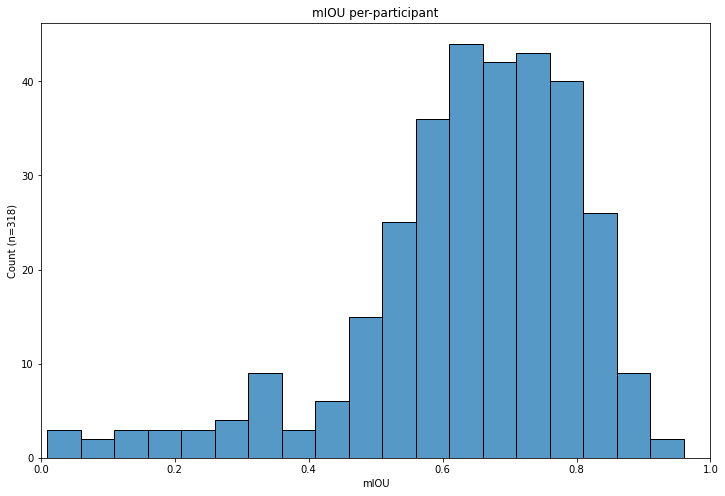

In [166]:
accuracies = []
textures = []
target = "userID"
challenging_stimuli = []
for index, trials in df.groupby(target): 
    accuracy = trials["miou"].mean()
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("mIOU")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"mIOU per-participant")
# plt.savefig(f"figures/{experimentName}/mean_miou_hist_per_{target}.png")

Text(0.5, 1.0, 'mIOU per-stimuli')

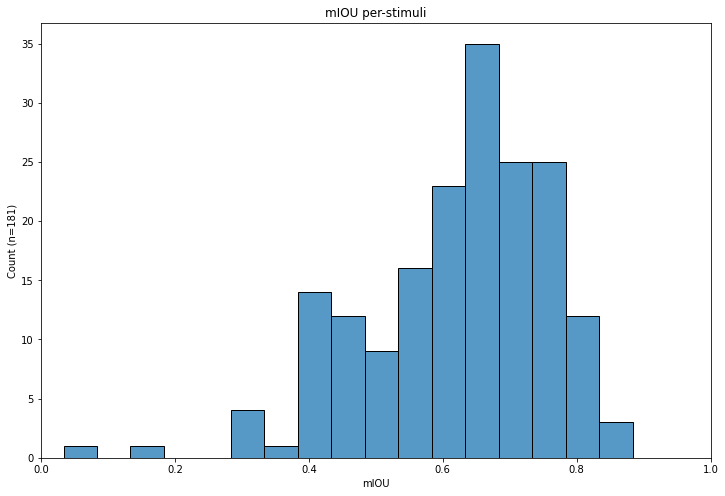

In [167]:
accuracies = []
textures = []
target = "stimulus"
challenging_stimuli = []
for index, trials in df.groupby(target): 
    accuracy = trials["miou"].mean()
    
    if accuracy < 0.25:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("mIOU")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"mIOU per-stimuli")
# plt.savefig(f"figures/{experimentName}/mean_miou_hist_per_{target}.png")

In [168]:
challenging_stimuli

[(0.03372999619521369,
  'https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt/images/image_019.png'),
 (0.17516143012284444,
  'https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt/images/image_086.png')]

In [169]:
def add_box(box, ax, alpha=0.8, color="red", linewidth=5):
    if len(box) != 4:
        box = process_box(box)
    width = box[2] - box[0]
    height = box[3] - box[1]
    if not color or color == "random":
        import random
        color = "#%06x" % random.randint(0, 0xFFFFFF)
        
    rect = patches.Rectangle((box[0], box[1]), width, height, linewidth=linewidth, edgecolor=color, 
                             alpha=alpha, facecolor='none')
    ax.add_patch(rect)
    return ax

def plot_trial(trial):
    fig, ax = plt.subplots(figsize=(16,12))
    print(trial["userID"])
    
    gt_bb = trial["gt_bounding_box"]
    s_bb = trial["subject_bounding_box"]
    
    print(gt_bb, s_bb)
    if gt_bb:
        add_box(gt_bb, ax, color="blue", alpha=0.75)
        
    if s_bb:
        add_box(s_bb, ax, color="red", alpha=0.75)
        
    url = trial["stimulus"]
    image = download_from_url(url)

    probe_location = trial["probe_location"]
    
    ax.imshow(image, cmap="gray")

    # Add probes
    probe = patches.Circle(probe_location, radius=12, color="#69597f", alpha=0.8)
    ax.add_patch(probe)
    probe = patches.Circle(probe_location, radius=4, color="#ff0601", alpha=1)
    ax.add_patch(probe)

    return fig

In [ ]:
for index, trial in df.iterrows():
    miou = calc_mIOU(trial["gt_bounding_box"], trial["subject_bounding_box"])
    print(miou)
    fig=plot_trial(trial)
    plt.show()
    plt.close()

In [ ]:
avg_bboxes = False
run_plots = True

# save_path = "/Users/yoni/Desktop/static_detection_v1_user_bboxes/"
# if not os.path.exists(save_path):
#     os.mkdir(save_path)
    
if run_plots:
    for index, trials in df.groupby("stimulus"):

        url = index
        image = download_from_url(url)

        # Add probes
        probe_locations = np.unique(trials["probe_location"])
        probe_touching = trials.iloc[0]["probe_touching"]

        if not probe_touching:
            continue 

        fig, ax = plt.subplots(1,1, figsize=(16, 12))
        image = download_from_url(url)

        ax.imshow(image, cmap="gray")
        for probe_location in probe_locations:
            probe = patches.Circle(probe_location, radius=12, color="#69597f", alpha=0.8)
            ax.add_patch(probe)

            probe = patches.Circle(probe_location, radius=4, color="#ff0601", alpha=1)
            ax.add_patch(probe)

        gt_bb = trials.iloc[0]["gt_bounding_box"]
        ax = add_box(gt_bb, ax, color="red", linewidth=10, alpha=1)

        avg_bb = []
        count = 0
        for i, trial in trials.iterrows():
            s_bb = trial["subject_bounding_box"]
            if s_bb:
                if avg_bboxes:
                    box = np.array(process_box(s_bb))
                    count += 1
                    if not len(avg_bb):
                        avg_bb.append(box)
                    else:
                        avg_bb.append(box)
                else: 
                    add_box(s_bb, ax, alpha=0.5, linewidth=5, color="random")

        if avg_bboxes:
            avg_bb = np.array(avg_bb).mean(axis=0)
            add_box(avg_bb, ax, alpha=0.9, linewidth=5, color="blue")
            miou = calc_mIOU(avg_bb, gt_bb)
            print(miou)
        

        trial_name = url.split(".com")[1][1:].replace("/", "-")
        trial_name = trial_name.replace("-images", "")

        plt.title(trial_name)
#         plt.savefig(os.path.join(save_path, trial_name + ".png"))
        plt.show()
        plt.close()